<a href="https://colab.research.google.com/github/ogigo/Generative_Aedversial_Network/blob/main/Generate_anime_face.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
api_token = {"username":"kajolmaster","key":"dbb23ceaca2a39397c3e92d83fda1034"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:json.dump(api_token, file)

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download splcher/animefacedataset

 99% 392M/395M [00:18<00:00, 22.8MB/s]
100% 395M/395M [00:18<00:00, 21.9MB/s]


In [ ]:
!unzip animefacedataset.zip

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, Reshape, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Conv2DTranspose

from tensorflow.compat.v1.keras.layers import BatchNormalization

In [ ]:
image_dataset=tf.keras.preprocessing.image_dataset_from_directory("/content/images",label_mode=None,image_size=(64,64),batch_size=128)

Found 63565 files belonging to 1 classes.


In [ ]:
next(iter(image_dataset))

In [ ]:
dataset = image_dataset.map(lambda x:(x/127.5)-1)

In [ ]:
next(iter(dataset))

(64, 64, 3)
128


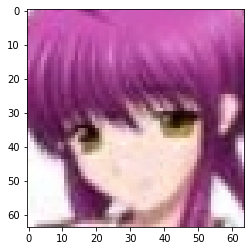

In [ ]:
for batch in dataset:
    plt.imshow(batch[0])
    print(batch[0].shape)
    print(len(batch))
    break

In [ ]:
generator=tf.keras.Sequential()
generator.add(tf.keras.layers.Input(shape=(100,)))
generator.add(tf.keras.layers.Dense(4*4*256))
generator.add(tf.keras.layers.BatchNormalization())
generator.add(tf.keras.layers.ReLU())

generator.add(tf.keras.layers.Reshape((4,4,256)))

generator.add(tf.keras.layers.Conv2DTranspose(128,kernel_size=4,padding="same",strides=2))
generator.add(tf.keras.layers.BatchNormalization())
generator.add(tf.keras.layers.ReLU())

generator.add(tf.keras.layers.Conv2DTranspose(64,kernel_size=4,padding="same",strides=2))
generator.add(tf.keras.layers.BatchNormalization())
generator.add(tf.keras.layers.ReLU())

generator.add(tf.keras.layers.Conv2DTranspose(32,kernel_size=4,padding="same",strides=2))
generator.add(tf.keras.layers.BatchNormalization())
generator.add(tf.keras.layers.ReLU())

generator.add(tf.keras.layers.Conv2DTranspose(3,kernel_size=4,padding="same",strides=2))
generator.add(tf.keras.layers.BatchNormalization())
generator.add(tf.keras.layers.Activation("tanh"))

In [ ]:
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4096)              413696    
                                                                 
 batch_normalization (BatchN  (None, 4096)             16384     
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        524416    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 128)       

In [ ]:
image_shape=(64,64,3)
discriminator=tf.keras.Sequential()
discriminator.add(tf.keras.layers.Conv2D(32,kernel_size=3,padding="Same",strides=2,input_shape=image_shape))
discriminator.add(tf.keras.layers.LeakyReLU(alpha=0.2))
discriminator.add(tf.keras.layers.Dropout(0.2))

discriminator.add(tf.keras.layers.Conv2D(64,kernel_size=3,strides=2,padding="same"))
discriminator.add(tf.keras.layers.ZeroPadding2D(padding=((0,1),(0,1))))
discriminator.add(tf.keras.layers.BatchNormalization(momentum=0.8))
discriminator.add(tf.keras.layers.LeakyReLU(alpha=0.2))
discriminator.add(tf.keras.layers.Dropout(0.25))

discriminator.add(tf.keras.layers.Conv2D(128, kernel_size=3, strides=2, padding="same"))
discriminator.add(tf.keras.layers.BatchNormalization(momentum=0.8))
discriminator.add(tf.keras.layers.LeakyReLU(alpha=0.2))
discriminator.add(tf.keras.layers.Dropout(0.25))

discriminator.add(tf.keras.layers.Conv2D(256, kernel_size=3, strides=1, padding="same"))
discriminator.add(tf.keras.layers.BatchNormalization(momentum=0.8))
discriminator.add(tf.keras.layers.LeakyReLU(alpha=0.2))
discriminator.add(tf.keras.layers.Dropout(0.25))

discriminator.add(tf.keras.layers.Flatten())
discriminator.add(tf.keras.layers.Dense(1))

In [ ]:
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 32)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 zero_padding2d (ZeroPadding  (None, 17, 17, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_10 (Bat  (None, 17, 17, 64)       256       
 chNormalization)                                     

In [ ]:
loss=tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def generator_loss(fake):
  gen_loss=loss(tf.ones_like(fake),fake)
  return gen_loss

In [ ]:
def discriminator_loss(real,fake):
  real_loss=loss(tf.ones_like(real),real)
  fake_loss=loss(tf.zeros_like(fake),fake)
  return real_loss,fake_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(0.0002,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0002,0.5)

In [ ]:
from tensorflow.python import training
@tf.function

def train_steps(images):
  noise=tf.random.normal([256,100])
  with tf.GradientTape() as gen_tape,tf.GradientTape() as disc_tape:
    generated_images=generator(noise,training=True)
    fake_output=discriminator(generated_images,training=True)
    real_output=discriminator(images,training=True)
    gen_loss=generator_loss(fake_output)
    disc_loss=discriminator_loss(real_output,fake_output)
  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  return gen_loss,disc_loss

In [ ]:
def train(dataset, epochs):
  gen_loss=0
  dis_loss=0
  gen_plot = []
  dis_plot = []
  for epoch in range(epochs):
    print(f'{epoch+1} of {epochs}',end = ' ')
    print(f'generator loss is {gen_loss} and discriminator loss is {dis_loss}')
    for image_batch in dataset: 
      gen_loss,dis_loss = train_steps(image_batch)
    gen_plot.append(gen_loss)
    dis_plot.append(dis_loss)
  x = [X for X in range(epochs)]
  plt.plot(x,gen_plot)
  plt.plot(x,dis_plot)
  plt.title('epoch vs loss')
  plt.legend(['gen_loss','dis_loss'])
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.show()

1 of 50 generator loss is 0 and discriminator loss is 0
2 of 50 generator loss is 5.911592960357666 and discriminator loss is (<tf.Tensor: shape=(), dtype=float32, numpy=0.23976038>, <tf.Tensor: shape=(), dtype=float32, numpy=0.019844064>)
3 of 50 generator loss is 3.169904947280884 and discriminator loss is (<tf.Tensor: shape=(), dtype=float32, numpy=0.04661353>, <tf.Tensor: shape=(), dtype=float32, numpy=0.19957101>)
4 of 50 generator loss is 4.41025972366333 and discriminator loss is (<tf.Tensor: shape=(), dtype=float32, numpy=0.19702686>, <tf.Tensor: shape=(), dtype=float32, numpy=0.05825959>)
5 of 50 generator loss is 3.0724072456359863 and discriminator loss is (<tf.Tensor: shape=(), dtype=float32, numpy=0.02713743>, <tf.Tensor: shape=(), dtype=float32, numpy=0.1846459>)
6 of 50 generator loss is 5.041208267211914 and discriminator loss is (<tf.Tensor: shape=(), dtype=float32, numpy=0.06733246>, <tf.Tensor: shape=(), dtype=float32, numpy=0.051986236>)
7 of 50 generator loss is 3.

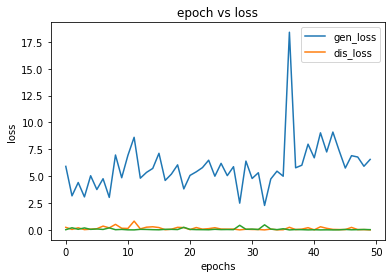

In [ ]:
train(dataset,50)

In [ ]:
noise = np.random.randn(32,100)
pred = generator.predict(noise)

1/1 [==============================] - 0s 15ms/step


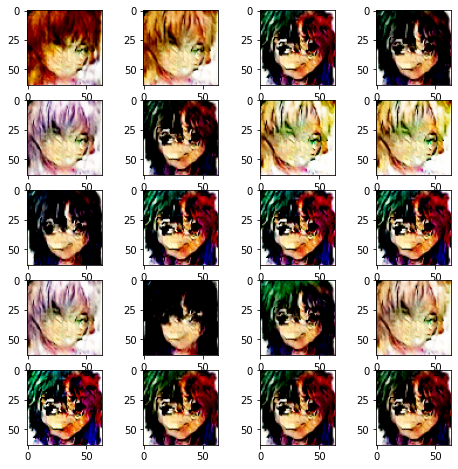

In [ ]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(pred[i])
plt.show()